In [1]:
import torch
from torch import Tensor
from torch.nn import Linear, MSELoss, functional as F
from torch.optim import SGD
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import classification_report
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# This file trains neural networks and validate test accuracy using extracted features on ASVspoof 2017 dataset

In [3]:
# load data
data_path = ".\data"

# each row is a sample
# label 1 for genuine data, 0 for recorded data
with open(os.path.join(data_path,'combined_void_phoneme_training_features.npy'), 'rb') as f:
    features = np.load(f)
with open(os.path.join(data_path,'training_labels.npy'), 'rb') as f:
    labels = np.load(f)

In [4]:
# standardization
scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=19)

# convert into tensor
X=torch.from_numpy(X_train).float().to(device)
y=torch.from_numpy(y_train).to(device)
Xtest=torch.from_numpy(X_test).float().to(device)
ytest=torch.from_numpy(y_test).to(device)

In [5]:
# define neural networks

# This is a basic 2-layer fully connected network
# It should be broad to push it into overparameterization regime
# best parameters so far: 70000 hidden neurons, 5e-3 learning rate, 99.5% test accuracy

# N is number of samples; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        # define layers and activation function
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H).to(device)
        self.linear2 = torch.nn.Linear(H, D_out).to(device)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # define forward pass
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        y_pred = self.linear2(x)
        return y_pred
    
    
class TenLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TenLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H).to(device)
        self.linear2 = torch.nn.Linear(H, H).to(device)
        self.linear3 = torch.nn.Linear(H, H).to(device)
        self.linear4 = torch.nn.Linear(H, H).to(device)
        self.linear5 = torch.nn.Linear(H, H).to(device)
        self.linear6 = torch.nn.Linear(H, H).to(device)
        self.linear7 = torch.nn.Linear(H, H).to(device)
        self.linear8 = torch.nn.Linear(H, H).to(device)
        self.linear9 = torch.nn.Linear(H, H).to(device)
        self.linear10 = torch.nn.Linear(H, D_out).to(device)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.relu(self.linear3(x))
        x = self.dropout(x)
        x = self.relu(self.linear4(x))
        x = self.dropout(x)
        x = self.relu(self.linear5(x))
        x = self.dropout(x)
        x = self.relu(self.linear6(x))
        x = self.dropout(x)
        x = self.relu(self.linear7(x))
        x = self.dropout(x)
        x = self.relu(self.linear8(x))
        x = self.dropout(x)
        x = self.relu(self.linear9(x))
        x = self.dropout(x)
        y_pred = self.linear10(x)
        return y_pred

In [6]:
# N is number of samples; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
def run(H=2000, learning_rate = 1e-3, num_epochs = 10000, 
        report_test_loss = True, NN_type = "TwoLayerNet", verbose = True, x=None, y =None, x_test = None, 
        y_test=None, weight_decay=0, early_stopping = False, early_stopping_acc=95, 
        decrease_learning_rate=False, decrease_learning_rate_after_epoch = 10000):

    D_in = x.shape[1]
    
    acc_training = []
    acc_test = []
    
    # Construct our model by instantiating the class defined above
    if NN_type == "TenLayerNet":
        model = TenLayerNet(D_in, H, 1)
    elif NN_type == "TwoLayerNet":
        model = TwoLayerNet(D_in, H, 1)
    model.to(device)

    # loss function and an Optimizer
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decrease_learning_rate_after_epoch, gamma=0.5) 
    
    #     training
    for t in range(num_epochs):
        # test accuracy
        if report_test_loss:
            model.eval()
            y_pred = model(x_test)
            y_pred_tag = torch.round(torch.sigmoid(y_pred))
            acc = (y_pred_tag == y_test).sum().float()/y_test.shape[0]* 100
            acc_test.append(acc.item())
            
            # early stopping if test accuracy is very good
            if early_stopping and acc_test[-1]>early_stopping_acc:
                target_names = ['genuine', 'recorded']
                print(classification_report(y_test.cpu().detach().numpy(), y_pred_tag.cpu().detach().numpy(), 
                                            target_names=target_names, digits=4))

                # add training acc
                acc_training.append(acc_training[-1])
                break
                
            
        # Forward pass. feed data
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)

        # Compute  loss
        loss = criterion(y_pred, y.float())

        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        acc = (y_pred_tag == y).sum().float()/y.shape[0]* 100
        acc_training.append(acc.item())

        # print loss
        if verbose and t % 100 == 99:
            print("epoch "+ str(t) + " training accuracy: ", acc.item())
            if report_test_loss:
                print("epoch "+ str(t) + "test accuracy: ", acc_test[-1])

        
        # backward pass. update weights based on gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t <= 3*decrease_learning_rate_after_epoch:
            scheduler.step()

    #   plot results
    epochs = range(0, len(acc_training))
    plt.yscale("log")
    plt.plot(epochs, acc_training, 'b', label="training acc")
    if report_test_loss:
        plt.plot(epochs, acc_test, 'r', label="test acc")
    plt.legend(loc="upper right")
    plt.show()
    
    if report_test_loss:
        print("test", acc_test[-1])
    print(acc_training[-1])
    
    model.eval()
    
    return acc_training, acc_test, model

In [7]:
results = {}

In [8]:
# train the neural network using the following hyper parameters
params = [("TwoLayerNet", 5e-3)]
Hs = [70000] # number of neurons in the hidden layer
weight_decay=1e-4
num_epochs = 20000

for NN_type, learning_rate in params:
    for H in Hs:
        acc_training, acc_test, model = run(H=H, learning_rate = learning_rate, num_epochs = num_epochs, 
            report_test_loss = True, NN_type = NN_type, verbose = True, x=X, y =y, x_test = Xtest, 
            y_test=ytest, weight_decay=weight_decay, early_stopping = True, early_stopping_acc=99.5,
            decrease_learning_rate=True, decrease_learning_rate_after_epoch = 5000)
        # store the resulting model in results
        results[(NN_type, learning_rate)] = (acc_training, acc_test, model)

99 98.67236328125
test 96.79557800292969
199 98.90943908691406
test 97.45855712890625
299 99.336181640625
test 97.67955780029297
399 99.28876495361328
test 97.79005432128906
499 99.47843170166016
test 97.79005432128906
599 99.38359832763672
test 98.34253692626953
699 99.47843170166016
test 98.45303344726562
799 99.6680908203125
test 98.56353759765625
899 99.62067413330078
test 98.7845230102539
999 99.71550750732422
test 98.67402648925781
1099 99.62067413330078
test 98.7845230102539
1199 99.71550750732422
test 98.67402648925781
1299 99.81034088134766
test 98.67402648925781
1399 99.62067413330078
test 98.7845230102539
1499 99.76292419433594
test 98.7845230102539
1599 99.81034088134766
test 98.7845230102539
1699 99.81034088134766
test 98.7845230102539
1799 99.76292419433594
test 98.7845230102539
1899 99.76292419433594
test 98.7845230102539
1999 99.71550750732422
test 98.89502716064453
2099 99.76292419433594
test 98.89502716064453
2199 99.76292419433594
test 98.89502716064453
2299 99.81034

KeyboardInterrupt: 

In [9]:
# save resulting model on disk
a_file = open("results.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

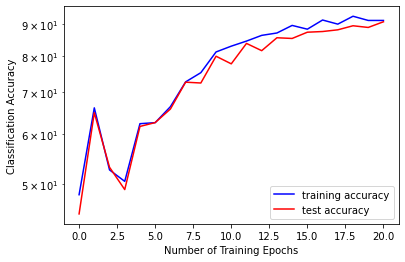

In [19]:
# plot results
acc_training, acc_test, model = results[("TwoLayerNet", 5e-3)]
epochs = range(0, len(acc_training))

f = plt.figure()
plt.yscale("log")
plt.plot(epochs, acc_training, 'b', label="training accuracy")
plt.plot(epochs, acc_test, 'r', label="test accuracy")
plt.xlabel("Number of Training Epochs")
plt.ylabel("Classification Accuracy")
plt.legend(loc="lower right")
plt.show()
f.savefig("Test Accuracy.pdf", bbox_inches='tight')

In [20]:
# produce detailed report
# False Positive Rate  = 1 - True negative rate
# False negative rate = 1 - True positive rate
y_pred = model(Xtest)
y_pred_tag = torch.round(torch.sigmoid(y_pred))
target_names = ['genuine', 'recorded']
print(classification_report(y_test, y_pred_tag.cpu().detach().numpy(), target_names=target_names, digits=4))

              precision    recall  f1-score   support

     genuine     0.9075    0.9134    0.9105       462
    recorded     0.9091    0.9029    0.9060       443

    accuracy                         0.9083       905
   macro avg     0.9083    0.9082    0.9082       905
weighted avg     0.9083    0.9083    0.9083       905

